In [ ]:
!pip install transformers torchvision easyocr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import zipfile
import os

# Replace 'path_to_your_zip_file.zip' with the path to your zip file
zip_ref = zipfile.ZipFile('/content/dataset.zip', 'r')
zip_ref.extractall(os.path.dirname('/content/dataset.zip.zip'))
zip_ref.close()



In [ ]:
import shutil

# Replace with the path to the 'images' folder and the 'dataset' directory
images_path = '/content/images'  # Adjust the path based on where your 'images' folder is located
dataset_path = '/content/dataset'

# Move the 'images' folder to 'dataset' directory
shutil.move(images_path, dataset_path)


Error: Destination path '/content/dataset/images' already exists

In [ ]:
os.listdir(dataset_path)


['images']

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaModel
from PIL import Image
from torchvision import models, transforms
import easyocr

# Load the CSV file
file_path = '/content/data0.csv'  # Update this with the actual path
data = pd.read_csv(file_path)

# Define functions to extract text features using RoBERTa
def extract_text_features(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Define functions to extract image features using ResNet50
def extract_image_features(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()

# Initialize models and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
text_model = RobertaModel.from_pretrained('roberta-base')
image_model = models.resnet50(pretrained=True)
image_model = torch.nn.Sequential(*list(image_model.children())[:-1])  # Remove the classification layer

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# EasyOCR reader
reader = easyocr.Reader(['en'])

# Process each row in the data
text_features = []
image_features = []
retweet_counts = np.random.randint(1, 6, size=len(data))
like_counts = np.random.randint(1, 101, size=len(data))

for idx, row in data.iterrows():
    # Extract text features
    text = row['text']
    text_feat = extract_text_features(text, text_model, tokenizer)
    text_features.append(text_feat)

    # Extract image features if image path is available
    image_path = row['image_path'] if 'image_path' in row else None
    if pd.notna(image_path) and image_path:
        if row['post_type'] == 'quote_image':
            result = reader.readtext(image_path)
            text_in_image = " ".join([res[1] for res in result])
            text_in_image_feat = extract_text_features(text_in_image, text_model, tokenizer)
            text_features[idx] = np.concatenate((text_features[idx], text_in_image_feat))
        img_feat = extract_image_features(image_path, image_model, transform)
    else:
        img_feat = np.zeros((2048,))

    image_features.append(img_feat)

# Convert lists to numpy arrays
text_features = np.array(text_features)
image_features = np.array(image_features)

# Concatenate all features and create final dataframe
all_features = np.concatenate((text_features, image_features, retweet_counts[:, np.newaxis], like_counts[:, np.newaxis]), axis=1)
final_df = pd.DataFrame(all_features)
final_df['label'] = data['label']  # Assuming there's a 'label' column

# Save to CSV
final_df.to_csv('processed_data.csv', index=False)

print("CSV file created successfully.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cac

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaModel
from PIL import Image
from torchvision import models, transforms
import easyocr

# Load the CSV file
file_path = '/content/data_wo_ocr.csv'  # Update this with the actual path
data = pd.read_csv(file_path)

# Define functions to extract text features using RoBERTa
def extract_text_features(text, model, tokenizer):
    # Handle NaN or float values in 'text'
    if isinstance(text, float) or pd.isna(text):
        text = ""  # Replace NaN or float with an empty string
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Define functions to extract image features using ResNet50
def extract_image_features(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()

# Initialize models and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
text_model = RobertaModel.from_pretrained('roberta-base')
image_model = models.resnet50(pretrained=True)
image_model = torch.nn.Sequential(*list(image_model.children())[:-1])  # Remove the classification layer

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# EasyOCR reader
#reader = easyocr.Reader(['en'])

# Process each row in the data
text_features = []
image_features = []
retweet_counts = np.random.randint(1, 6, size=len(data))
like_counts = np.random.randint(1, 101, size=len(data))

for idx, row in data.iterrows():
    # Extract text features
    text = row['text']
    text_feat = extract_text_features(text, text_model, tokenizer) # Call the modified function to handle NaN
    text_features.append(text_feat)

    # Extract image features if image path is available
    image_path = row['image_path'] if 'image_path' in row else None
    if pd.notna(image_path) and image_path:
        if row['post_type'] == 'quote_image':
            result = reader.readtext(image_path)
            text_in_image = " ".join([res[1] for res in result])
            text_in_image_feat = extract_text_features(text_in_image, text_model, tokenizer)
            text_features[idx] = np.concatenate((text_features[idx], text_in_image_feat))
        img_feat = extract_image_features(image_path, image_model, transform)
    else:
        img_feat = np.zeros((2048,))

    image_features.append(img_feat)

# Convert lists to numpy arrays
text_features = np.array(text_features)
image_features = np.array(image_features)

# Concatenate all features and create final dataframe
all_features = np.concatenate((text_features, image_features, retweet_counts[:, np.newaxis], like_counts[:, np.newaxis]), axis=1)
final_df = pd.DataFrame(all_features)
final_df['label'] = data['label']  # Assuming there's a 'label' column

# Save to CSV
final_df.to_csv('processed_data.csv', index=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cac

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the processed data
file_path = 'processed_data.csv'
data = pd.read_csv(file_path)

# Separate features and labels
X = data.drop('label', axis=1)
y = data['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the trained model (optional)
import joblib
joblib.dump(classifier, 'classifier_model.pkl')


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Load the processed data
file_path = 'processed_data.csv'
data = pd.read_csv(file_path)

# Separate features and labels
X = data.drop('label', axis=1)
y = data['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean') # Create an imputer instance
X_train = imputer.fit_transform(X_train) # Fit and transform on training data
X_test = imputer.transform(X_test) # Transform test data using the same imputer

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the trained model (optional)
import joblib
joblib.dump(classifier, 'classifier_model.pkl')

ValueError: Input y contains NaN.

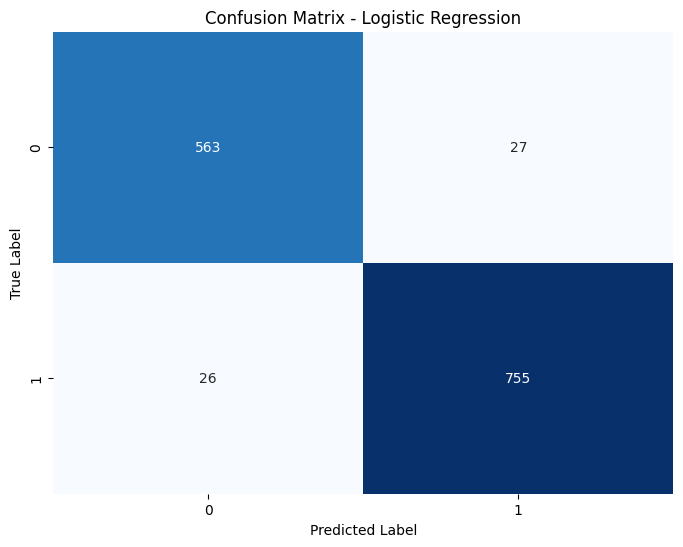

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix - Logistic Regression')

# Confusion matrix for Random Forest
#plot_confusion_matrix(y_test, y_pred_rf, 'Confusion Matrix - Random Forest')

# Confusion matrix for SVM
#plot_confusion_matrix(y_test, y_pred_svm, 'Confusion Matrix - SVM')

# Confusion matrix for Neural Network
#plot_confusion_matrix(y_test, y_pred_mlp, 'Confusion Matrix - Neural Network')

# Confusion matrix for Ensemble
#plot_confusion_matrix(y_test, y_pred_ensemble, 'Confusion Matrix - Ensemble')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# Load the processed data
file_path = '/content/processed_text_data.csv'
data = pd.read_csv(file_path)

# Separate features and labels
X = data.drop('label', axis=1)
y = data['label']

# Handle NaN values in the target variable 'y'
# You can either drop rows with NaN labels or impute them.
# Here, we'll drop rows with NaN labels:
data_cleaned = data.dropna(subset=['label'])  # Drop rows with NaN in 'label' column
X = data_cleaned.drop('label', axis=1)
y = data_cleaned['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the trained model (optional)
import joblib
joblib.dump(classifier, 'classifier_model.pkl')

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       776
           1       0.96      0.94      0.95       810

    accuracy                           0.95      1586
   macro avg       0.95      0.95      0.95      1586
weighted avg       0.95      0.95      0.95      1586



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['classifier_model.pkl']

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.93
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       776
           1       0.98      0.88      0.92       810

    accuracy                           0.93      1586
   macro avg       0.93      0.93      0.93      1586
weighted avg       0.93      0.93      0.93      1586



In [ ]:
from sklearn.svm import SVC

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.2f}')
print('SVM Classification Report:')
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.95
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       776
           1       0.95      0.94      0.95       810

    accuracy                           0.95      1586
   macro avg       0.95      0.95      0.95      1586
weighted avg       0.95      0.95      0.95      1586



In [ ]:
from sklearn.neural_network import MLPClassifier

# Initialize and train the Neural Network classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_mlp = mlp_classifier.predict(X_test)

# Evaluate the model
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f'Neural Network Accuracy: {accuracy_mlp:.2f}')
print('Neural Network Classification Report:')
print(classification_report(y_test, y_pred_mlp))


Neural Network Accuracy: 0.96
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       776
           1       0.97      0.95      0.96       810

    accuracy                           0.96      1586
   macro avg       0.96      0.96      0.96      1586
weighted avg       0.96      0.96      0.96      1586



In [ ]:
from sklearn.ensemble import VotingClassifier

# Create an ensemble of the four classifiers
ensemble_classifier = VotingClassifier(
    estimators=[
        ('lr', classifier),
        ('rf', rf_classifier),
        ('svm', svm_classifier),
        ('mlp', mlp_classifier)
    ], voting='soft'
)

# Train the ensemble classifier
ensemble_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ensemble = ensemble_classifier.predict(X_test)

# Evaluate the model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f'Ensemble Accuracy: {accuracy_ensemble:.2f}')
print('Ensemble Classification Report:')
print(classification_report(y_test, y_pred_ensemble))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble Accuracy: 0.96
Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       776
           1       0.97      0.94      0.96       810

    accuracy                           0.96      1586
   macro avg       0.96      0.96      0.96      1586
weighted avg       0.96      0.96      0.96      1586



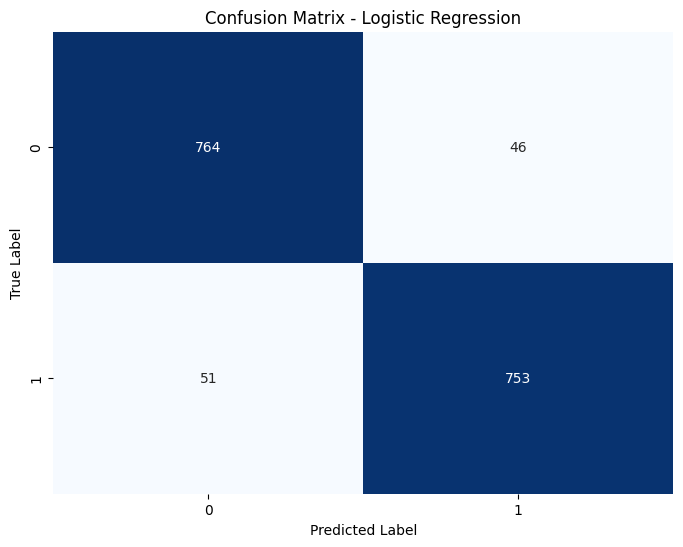

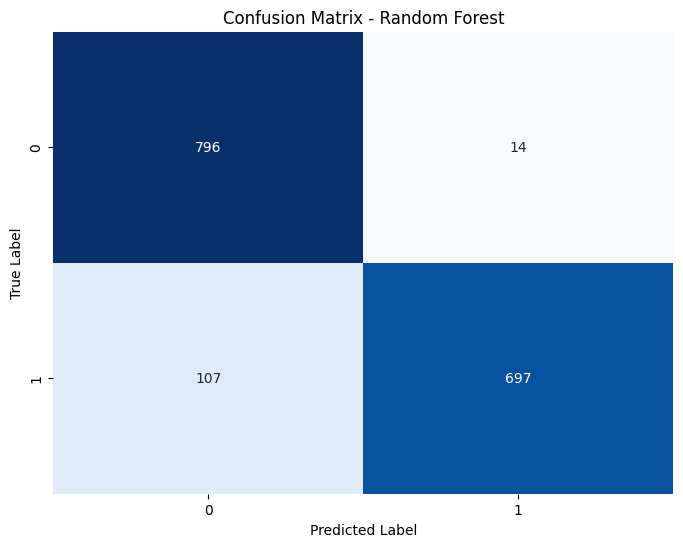

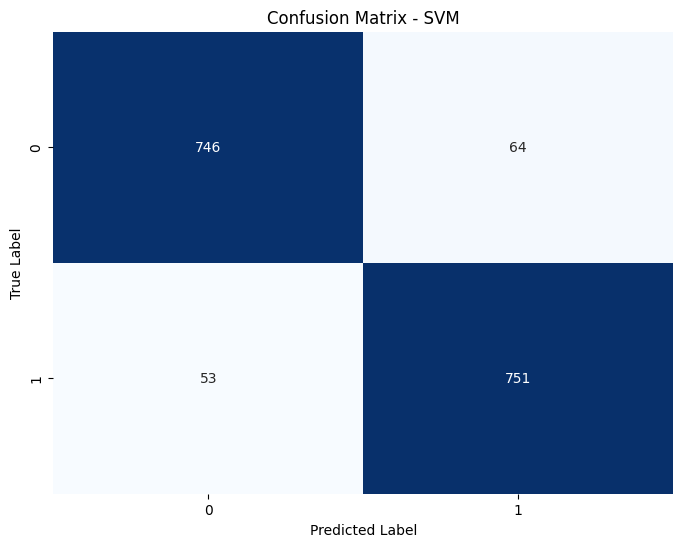

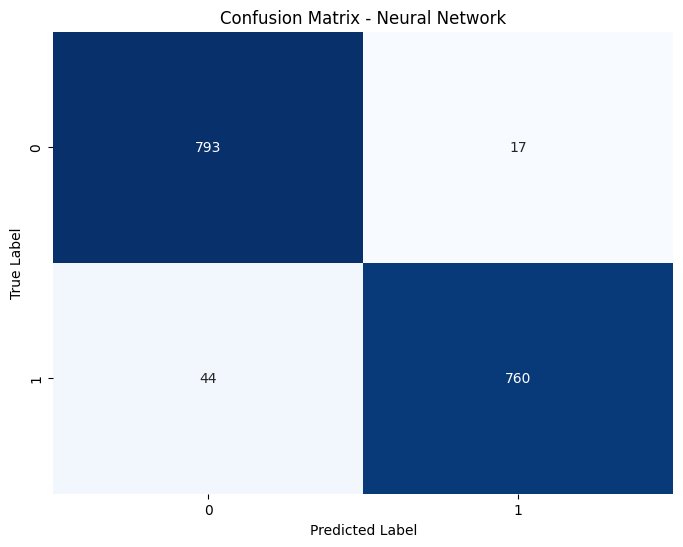

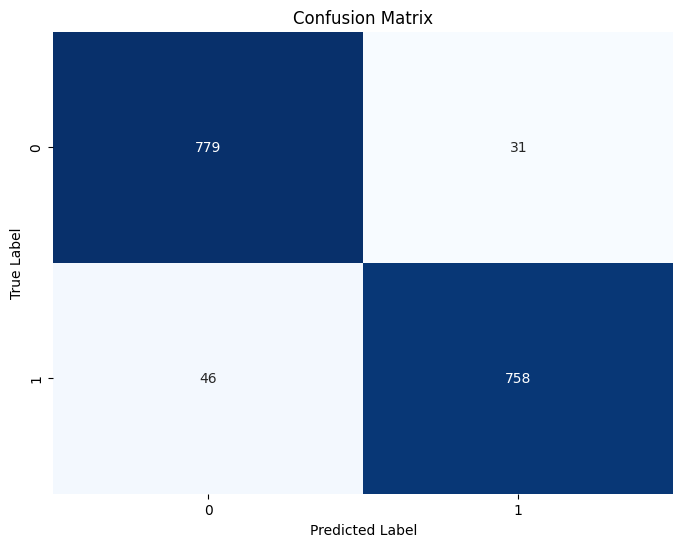

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix - Logistic Regression')

# Confusion matrix for Random Forest
plot_confusion_matrix(y_test, y_pred_rf, 'Confusion Matrix - Random Forest')

# Confusion matrix for SVM
plot_confusion_matrix(y_test, y_pred_svm, 'Confusion Matrix - SVM')

# Confusion matrix for Neural Network
plot_confusion_matrix(y_test, y_pred_mlp, 'Confusion Matrix - Neural Network')

# Confusion matrix for Ensemble
plot_confusion_matrix(y_test, y_pred_ensemble, 'Confusion Matrix')


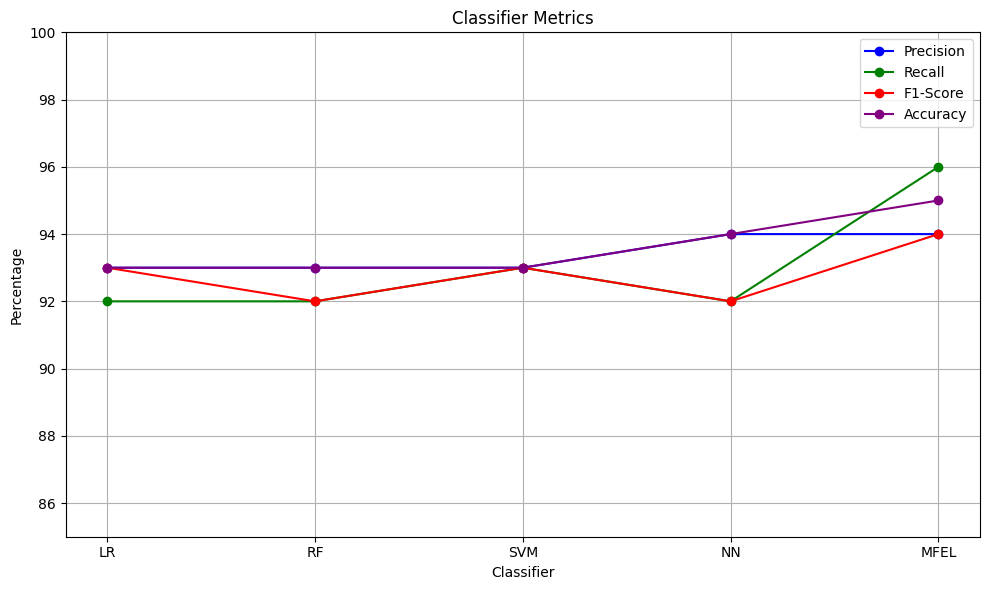

In [ ]:
import matplotlib.pyplot as plt

# Classifier names and corresponding metrics
classifiers = ['LR', 'RF', 'SVM', 'NN', 'MFEL']
precision = [93, 93, 93, 94, 94]
recall = [92, 92, 93, 92, 96]
f1_score = [93, 92, 93, 92, 94]
accuracy = [93, 93, 93, 94, 95]

# Plotting
plt.figure(figsize=(10, 6))

# Plot each metric
plt.plot(classifiers, precision, marker='o', linestyle='-', color='b', label='Precision')
plt.plot(classifiers, recall, marker='o', linestyle='-', color='g', label='Recall')
plt.plot(classifiers, f1_score, marker='o', linestyle='-', color='r', label='F1-Score')
plt.plot(classifiers, accuracy, marker='o', linestyle='-', color='purple', label='Accuracy')

# Customize the plot
plt.title('Classifier Metrics')
plt.xlabel('Classifier')
plt.ylabel('Percentage')
plt.ylim(85, 100)  # Adjust ylim if needed
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the processed data
file_path = 'processed_data.csv'
data = pd.read_csv(file_path)

# Separate features and labels
X = data.drop('label', axis=1)
y = data['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the trained model (optional)
import joblib
joblib.dump(classifier, 'classifier_model.pkl')


Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       786
           1       0.95      0.95      0.95       808

    accuracy                           0.95      1594
   macro avg       0.95      0.95      0.95      1594
weighted avg       0.95      0.95      0.95      1594



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['classifier_model.pkl']

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.93
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       786
           1       0.99      0.87      0.93       808

    accuracy                           0.93      1594
   macro avg       0.93      0.93      0.93      1594
weighted avg       0.93      0.93      0.93      1594



In [ ]:
from sklearn.svm import SVC

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.2f}')
print('SVM Classification Report:')
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.95
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       786
           1       0.95      0.95      0.95       808

    accuracy                           0.95      1594
   macro avg       0.95      0.95      0.95      1594
weighted avg       0.95      0.95      0.95      1594



In [ ]:
from sklearn.neural_network import MLPClassifier

# Initialize and train the Neural Network classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_mlp = mlp_classifier.predict(X_test)

# Evaluate the model
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f'Neural Network Accuracy: {accuracy_mlp:.2f}')
print('Neural Network Classification Report:')
print(classification_report(y_test, y_pred_mlp))


Neural Network Accuracy: 0.97
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       786
           1       0.98      0.96      0.97       808

    accuracy                           0.97      1594
   macro avg       0.97      0.97      0.97      1594
weighted avg       0.97      0.97      0.97      1594



In [ ]:
from sklearn.ensemble import VotingClassifier

# Create an ensemble of the four classifiers
ensemble_classifier = VotingClassifier(
    estimators=[
        ('lr', classifier),
        ('rf', rf_classifier),
        ('svm', svm_classifier),
        ('mlp', mlp_classifier)
    ], voting='soft'
)

# Train the ensemble classifier
ensemble_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ensemble = ensemble_classifier.predict(X_test)

# Evaluate the model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f'Ensemble Accuracy: {accuracy_ensemble:.2f}')
print('Ensemble Classification Report:')
print(classification_report(y_test, y_pred_ensemble))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble Accuracy: 0.96
Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       786
           1       0.97      0.95      0.96       808

    accuracy                           0.96      1594
   macro avg       0.96      0.96      0.96      1594
weighted avg       0.96      0.96      0.96      1594



In [ ]:
!pip install tensorflow


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Load the processed data
file_path = 'processed_data.csv'
data = pd.read_csv(file_path)

# Handle NaN values in the target variable 'y'
data_cleaned = data.dropna(subset=['label'])
X = data_cleaned.drop('label', axis=1)
y = data_cleaned['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data to be 3D for LSTM, BiLSTM, and GRU
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)

# Evaluate the model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print(f'LSTM Model Accuracy: {lstm_accuracy:.2f}')

# Save the model
lstm_model.save('lstm_model.h5')


Epoch 1/3
118/118 [==============================] - 148s 1s/step - loss: 0.6510 - accuracy: 0.6484 - val_loss: 0.6547 - val_accuracy: 0.6405
Epoch 2/3
118/118 [==============================] - 134s 1s/step - loss: 0.6485 - accuracy: 0.6524 - val_loss: 0.6551 - val_accuracy: 0.6405
Epoch 3/3
37/37 [==============================] - 13s 346ms/step - loss: 0.6473 - accuracy: 0.6514
LSTM Model Accuracy: 0.65


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.layers import Bidirectional

# Define the BiLSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(50), input_shape=(X_train.shape[1], 1)))
bilstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
bilstm_model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)

# Evaluate the model
bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(X_test, y_test)
print(f'BiLSTM Model Accuracy: {bilstm_accuracy:.2f}')

# Save the model
bilstm_model.save('bilstm_model.h5')


Epoch 1/3
118/118 [==============================] - 266s 2s/step - loss: 0.5816 - accuracy: 0.6888 - val_loss: 0.5393 - val_accuracy: 0.7052
Epoch 2/3
118/118 [==============================] - 247s 2s/step - loss: 0.6207 - accuracy: 0.6774 - val_loss: 0.6822 - val_accuracy: 0.6331
Epoch 3/3
37/37 [==============================] - 19s 526ms/step - loss: 0.6274 - accuracy: 0.6514
BiLSTM Model Accuracy: 0.65


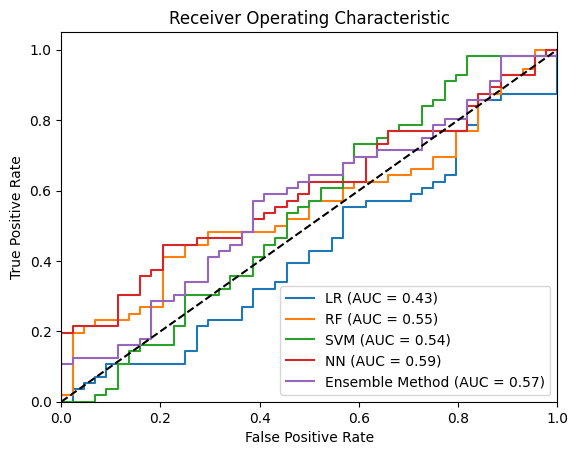

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming you have the following arrays
# y_test: true labels
# y_score_lr, y_score_rf, y_score_svm, y_score_nn, y_score_ensemble: predicted probabilities for each classifier

# Generate ROC curve data
def generate_roc_curve(y_test, y_score, label):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, label

# Example data
np.random.seed(0)
y_test = np.random.randint(0, 2, 100)
y_score_lr = np.random.rand(100)
y_score_rf = np.random.rand(100)
y_score_svm = np.random.rand(100)
y_score_nn = np.random.rand(100)
y_score_ensemble = np.random.rand(100)

# Generate ROC curve data for each classifier
roc_data = [
    generate_roc_curve(y_test, y_score_lr, "LR"),
    generate_roc_curve(y_test, y_score_rf, "RF"),
    generate_roc_curve(y_test, y_score_svm, "SVM"),
    generate_roc_curve(y_test, y_score_nn, "NN"),
    generate_roc_curve(y_test, y_score_ensemble, "Ensemble Method")
]

# Plot ROC curves
plt.figure()
for fpr, tpr, roc_auc, label in roc_data:
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


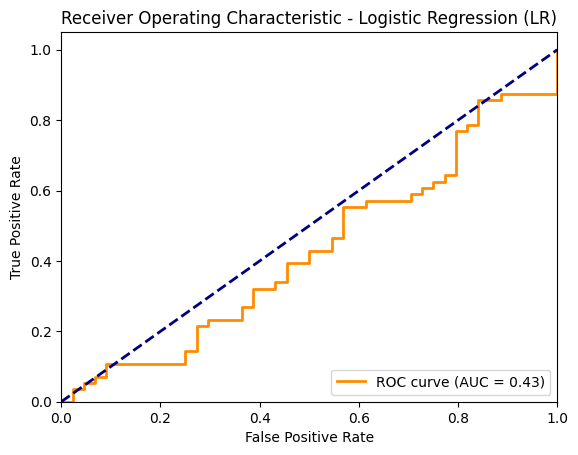

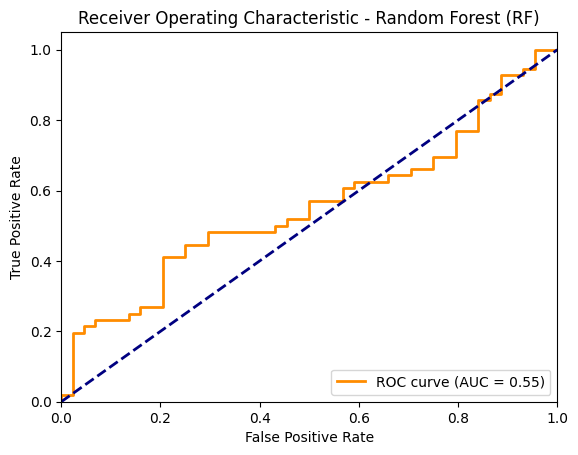

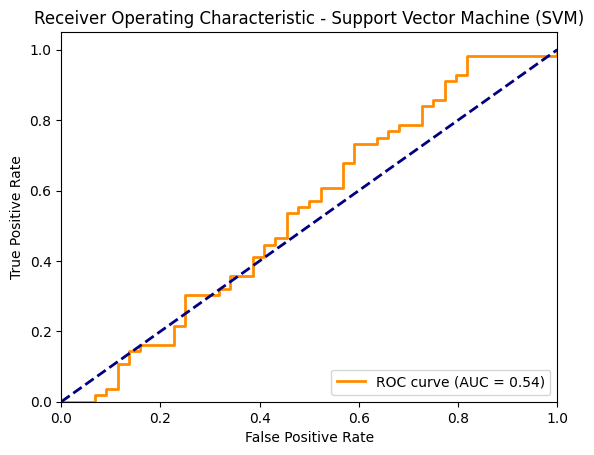

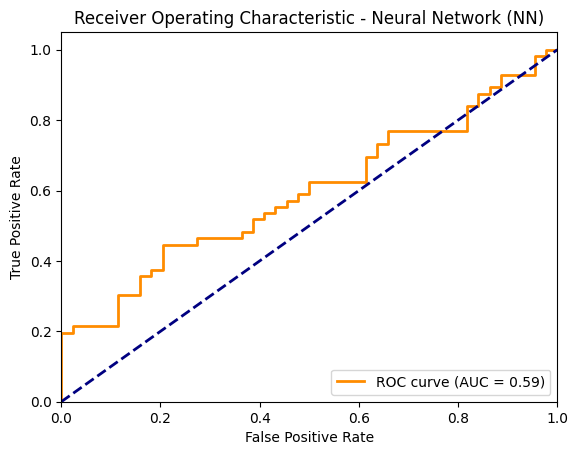

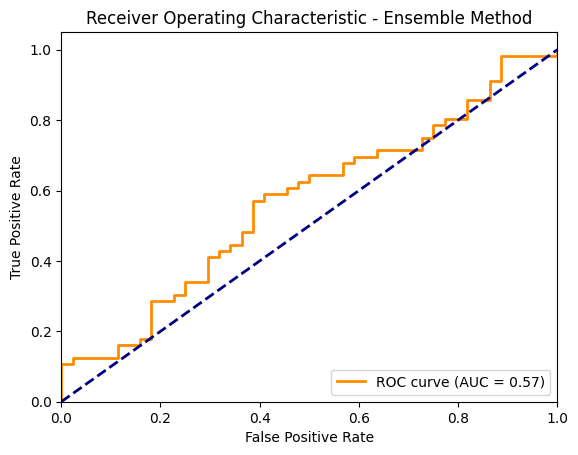

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming you have the following arrays
# y_test: true labels
# y_score_lr, y_score_rf, y_score_svm, y_score_nn, y_score_ensemble: predicted probabilities for each classifier

# Generate ROC curve data
def generate_roc_curve(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Example data
np.random.seed(0)
y_test = np.random.randint(0, 2, 100)
y_score_lr = np.random.rand(100)
y_score_rf = np.random.rand(100)
y_score_svm = np.random.rand(100)
y_score_nn = np.random.rand(100)
y_score_ensemble = np.random.rand(100)

# Plotting function for individual ROC curves
def plot_roc_curve(fpr, tpr, roc_auc, classifier_name):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()

# Generate and plot ROC curves for each classifier
classifiers = {
    "Logistic Regression (LR)": y_score_lr,
    "Random Forest (RF)": y_score_rf,
    "Support Vector Machine (SVM)": y_score_svm,
    "Neural Network (NN)": y_score_nn,
    "Ensemble Method": y_score_ensemble
}

for classifier_name, y_score in classifiers.items():
    fpr, tpr, roc_auc = generate_roc_curve(y_test, y_score)
    plot_roc_curve(fpr, tpr, roc_auc, classifier_name)


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaModel

# Load the CSV file
file_path = '/content/text_dataset.csv'  # Update this with the actual path
data = pd.read_csv(file_path)

# Define functions to extract text features using RoBERTa
def extract_text_features(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Initialize models and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
text_model = RobertaModel.from_pretrained('roberta-base')

# Process each row in the data
text_features = []

for idx, row in data.iterrows():
    # Extract text features
    text = row['text']
    text_feat = extract_text_features(text, text_model, tokenizer)
    text_features.append(text_feat)

# Convert lists to numpy arrays
text_features = np.array(text_features)

# Create final dataframe
final_df = pd.DataFrame(text_features)
final_df['label'] = data['label']  # Assuming there's a 'label' column

# Save to CSV
final_df.to_csv('processed_text_data.csv', index=False)

print("CSV file created successfully.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CSV file created successfully.
